## 🧭 Notebook 4 — Model Interpretability and Economic Drivers of Hotel Demand (2015 – 2026)

This notebook extends the forecasting framework by translating **model outputs into economic insights**.  
Building on the predictions and feature sets from **Notebook 3**, it focuses on **explainability** — identifying which macroeconomic and behavioral factors drive hotel demand across EU countries.

It integrates **machine-learning interpretability (SHAP)** and **econometric panel regressions** to bridge data-driven forecasts with transparent, theory-based reasoning.

---

### 🎯 Objectives
- Apply **SHAP (Shapley Additive Explanations)** to interpret feature contributions in **XGBoost** and **LightGBM** models.  
- Quantify economic relationships between model forecasts and macro indicators using **panel regressions with fixed effects**.  
- Visualize and compare the **magnitude** and **direction** of macroeconomic drivers across all model families (Naive, ARIMAX, SARIMAX, XGBoost, LightGBM).  
- Export interpretable results and visual summaries for downstream reporting and policy applications.

---

### **Structure Overview**
0. Environment Setup  
1. Load Processed Data and Model Predictions  
2. Data Readiness and Alignment  
3. SHAP Explainability (XGBoost + LightGBM)  
4. Panel Regression Analysis (Model Explainability)  
5. Visualize Macroeconomic Drivers Across Models  
6. Export Regression Results and Visualizations  
7. Summary and Handoff  

---

**Inputs**  
📂 `../data/processed/hotel_predictions.csv`  
📂 `../outputs/models/pipe_xgb.pkl`  
📂 `../outputs/models/pipe_lgbm.pkl`  
📂 `../outputs/models/X_train_shap.parquet`  
📂 `../outputs/models/X_train_columns.json`

**Outputs**  
📂 `../outputs/figures/shap_summary_xgb.png`  
📂 `../outputs/figures/shap_summary_lgbm.png`  
📂 `../outputs/figures/shap_bar_xgb.png`  
📂 `../outputs/figures/shap_bar_lgbm.png`  
📂 `../outputs/figures/shap_dependence_xgb_log_gdp_lag1.png`  
📂 `../outputs/figures/shap_dependence_lgbm_log_gdp_lag1.png`  
📂 `../outputs/reports/driver_regression_summary.csv`  

> **Interpretation Insights — Model Explainability and Economic Drivers**
>
> This notebook connects the predictive power of machine-learning models with transparent economic interpretation.  
> By combining **SHAP explainability** (for XGBoost & LightGBM) and **panel regressions with fixed effects**, it uncovers how macroeconomic indicators shape hotel-demand forecasts across the EU.
>
> **SHAP-based insights**
> - Both **XGBoost** and **LightGBM** identify `log_gdp` and `turnover_index` as the dominant positive drivers of hotel nights.  
> - Lagged GDP and turnover variables capture *persistence* in demand dynamics.  
> - `weighted_stringency_index` shows a mild **negative impact**, consistent with post-pandemic recovery.  
> - Currency and regional effects (e.g., `eurusd`, `region_LU`) have secondary but interpretable roles.
>
> **Panel-regression validation**
> - Across Naive, ARIMAX, SARIMAX, and ML forecasts, **GDP lag 1** remains a significant long-run determinant.  
> - **Turnover growth** explains short-run cyclical variation, while **policy stringency** remains mildly contractionary.  
> - **Unemployment** effects are weak once GDP and turnover are controlled for.  
>
> The convergence between SHAP patterns and regression coefficients confirms that **machine-learning models internalize economically meaningful structures**, not mere statistical artifacts.  
> This interpretability layer ensures theoretical consistency and strengthens the credibility of forecasts used in **Notebook 5 — Scenario Forecasting and Policy Simulations (2025 – 2026)**.

---

**Purpose:**  
To provide an integrated interpretability layer connecting **machine-learning forecasts** with **macroeconomic theory**, paving the way for **Notebook 5 — Scenario Forecasting and Policy Simulations (2025 – 2026)**.

In [1]:
# %% ===============================================================
# STEP 0 — ENVIRONMENT SETUP
# ===============================================================
# ruff: noqa: E402

import sys
from pathlib import Path

# --- Project path setup ---
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

# --- Imports ---
from utils.explainability import (
    compute_shap_values,
    summarize_shap,
    dependence_plot,
    run_panel_regression,
)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap  # noqa: F401
import joblib
import json
import statsmodels.api as sm  # noqa: F401
import warnings

# --- Visualization & warnings ---
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("viridis")
warnings.filterwarnings("ignore")

# --- Directories ---
BASE_DIR = Path("..")
DATA_PROCESSED = BASE_DIR / "data" / "processed"
OUTPUTS = BASE_DIR / "outputs"
FIGURES = OUTPUTS / "figures"
MODELS = OUTPUTS / "models"
REPORTS = OUTPUTS / "reports"

for path in [DATA_PROCESSED, FIGURES, MODELS, REPORTS]:
    path.mkdir(parents=True, exist_ok=True)

print("✅ Environment setup complete.")

✅ Environment setup complete.


In [2]:
# %% ===============================================================
# STEP 1 — LOAD PROCESSED DATA AND MODEL PREDICTIONS
# Purpose: Import the unified dataset and all model outputs needed for interpretability.
# ===============================================================

# type: ignore[name-defined]

# --- Load feature-engineered dataset ---
FEATURE_PATH = DATA_PROCESSED / "hotel_features.csv"
df_features = pd.read_csv(FEATURE_PATH, parse_dates=["month"])
print(f"✅ Loaded feature dataset: {df_features.shape} | {FEATURE_PATH.name}")

# --- Load combined predictions (includes yhat_naive, yhat_arimax, yhat_sarimax, yhat_xgb, yhat_lgbm) ---
PRED_PATH = DATA_PROCESSED / "hotel_predictions.csv"
df = pd.read_csv(PRED_PATH, parse_dates=["month"])
print(f"✅ Loaded master predictions: {df.shape} | {PRED_PATH.name}")

# --- Quick structure check ---
pred_cols = [c for c in df.columns if c.startswith("yhat_")]
print(f"[INFO] Available prediction columns: {pred_cols}")

# --- Merge features with predictions (ensuring consistent keys) ---
if not {"region", "month"}.issubset(df.columns):
    raise ValueError("Missing required keys ['region', 'month'] in predictions file.")

df_full = (
    df_features.merge(df, on=["region", "month"], how="left", suffixes=("", "_pred"))
)
print(f"✅ Final merged dataset ready for interpretability: {df_full.shape}")

df_full.head()

✅ Loaded feature dataset: (3328, 30) | hotel_features.csv
✅ Loaded master predictions: (3328, 35) | hotel_predictions.csv
[INFO] Available prediction columns: ['yhat_naive', 'yhat_arimax', 'yhat_sarimax', 'yhat_xgb', 'yhat_lgbm']
✅ Final merged dataset ready for interpretability: (3328, 63)


,region,month,year,log_nights_spent,log_gdp_lag1,log_gdp_lag2,log_gdp_lag3,unemployment_rate_lag1,unemployment_rate_lag2,unemployment_rate_lag3,...,unemployment_rate_pred,turnover_index_pred,weighted_stringency_index_pred,eurusd_pred,eurgbp_pred,yhat_naive,yhat_arimax,yhat_sarimax,yhat_xgb,yhat_lgbm
0,AT,2015-01-01,2015,14.421982,NaN,NaN,NaN,NaN,NaN,NaN,...,5.5,31.0,44.671611,1.128796,0.748800,NaN,NaN,NaN,NaN,NaN
1,AT,2015-02-01,2015,14.578970,11.021584,NaN,NaN,5.5,NaN,NaN,...,5.9,31.0,44.671611,1.119796,0.726058,14.421982,NaN,NaN,NaN,NaN
2,AT,2015-03-01,2015,14.475429,11.028797,11.021584,NaN,5.9,5.5,NaN,...,5.4,31.0,44.671611,1.083025,0.731200,14.578970,NaN,NaN,NaN,NaN
3,AT,2015-04-01,2015,14.199757,11.035960,11.028797,11.021584,5.4,5.9,5.5,...,5.6,31.0,44.671611,1.111432,0.720400,14.475429,NaN,NaN,NaN,NaN
4,AT,2015-05-01,2015,14.399386,11.043071,11.035960,11.028797,5.6,5.4,5.9,...,5.8,31.0,44.671611,1.096035,0.715400,14.199757,NaN,NaN,NaN,NaN


In [3]:
# %% ===============================================================
# STEP 2 — DATA READINESS & ALIGNMENT
# Purpose: Prepare unified dataset for interpretability and driver analysis.
# ===============================================================

# type: ignore[name-defined]

# --- Copy main dataset for safety ---
df = df_full.copy()

# --- Check and enforce datetime consistency ---
df["month"] = pd.to_datetime(df["month"])
df["year"] = df["month"].dt.year
df["quarter"] = df["month"].dt.to_period("Q").astype(str)

# --- Drop rows with missing key identifiers ---
df = df.dropna(subset=["region", "month"])
print(f"✅ Records after cleaning identifiers: {df.shape}")

# --- Identify available prediction columns ---
pred_cols = [c for c in df.columns if c.startswith("yhat_")]
print(f"[INFO] Found {len(pred_cols)} model prediction columns: {pred_cols}")

# --- Ensure numeric columns have proper dtype ---
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors="coerce")

# --- Verify alignment between features and predictions ---
required_cols = ["region", "month", "log_nights_spent"]
missing_cols = [c for c in required_cols if c not in df.columns]
if missing_cols:
    raise ValueError(f"Missing required columns: {missing_cols}")

print(f"✅ Dataset aligned and ready — {df.shape[0]} rows × {df.shape[1]} columns")

# --- Optional quick check: one sample per region ---
df.groupby("region")["month"].min().head()

✅ Records after cleaning identifiers: (3328, 64)
[INFO] Found 5 model prediction columns: ['yhat_naive', 'yhat_arimax', 'yhat_sarimax', 'yhat_xgb', 'yhat_lgbm']
✅ Dataset aligned and ready — 3328 rows × 64 columns


region
AT   2015-01-01
BE   2015-01-01
BG   2015-01-01
CY   2015-01-01
CZ   2015-01-01
Name: month, dtype: datetime64[ns]

✅ Data loaded: 2808 rows × 53 features
⚠️ TreeExplainer failed: could not convert string to float: '[1.3403345E1]'
→ Using fallback (PermutationExplainer, safe mode).


PermutationExplainer explainer: 501it [00:31, 11.79it/s]                         


✅ SHAP values computed successfully (safe mode).
✅ TreeExplainer succeeded for LGBMRegressor.
🔹 Plotting XGBoost SHAP summaries...


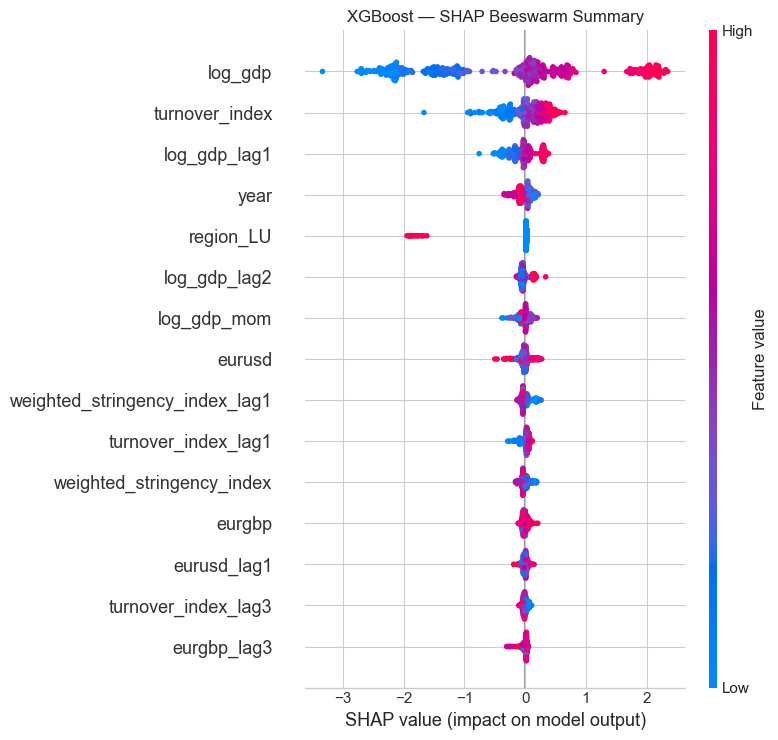

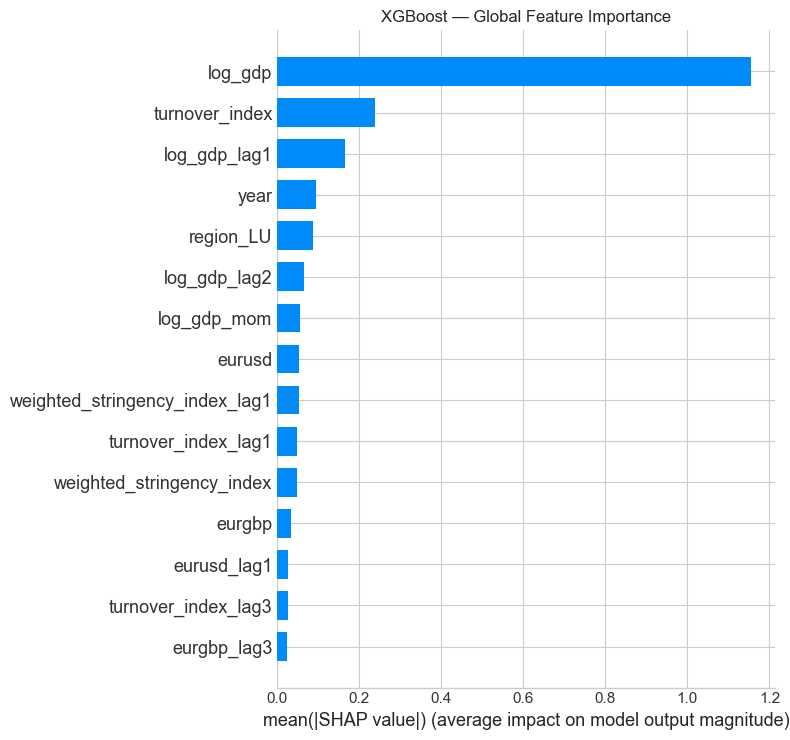

🔹 Plotting LightGBM SHAP summaries...


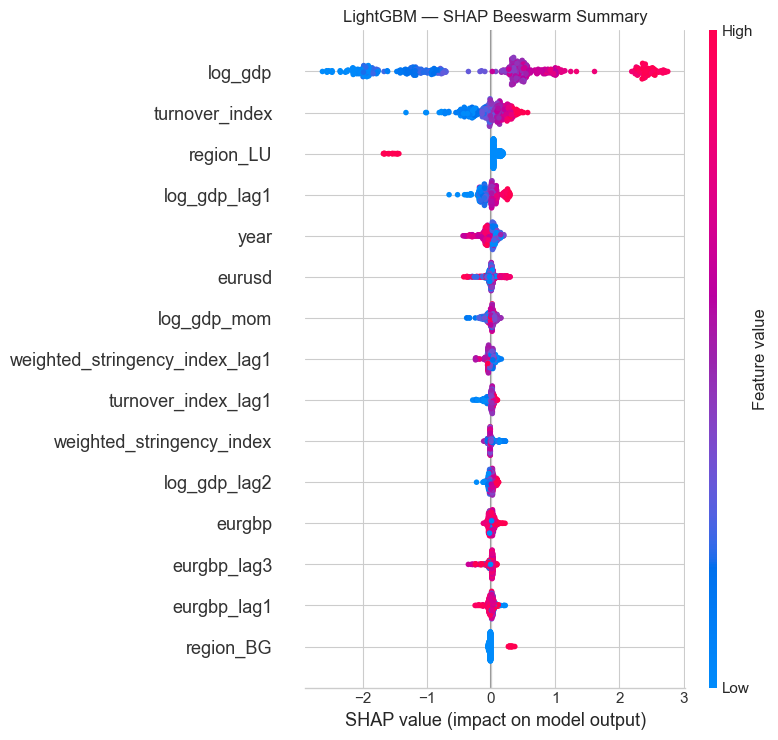

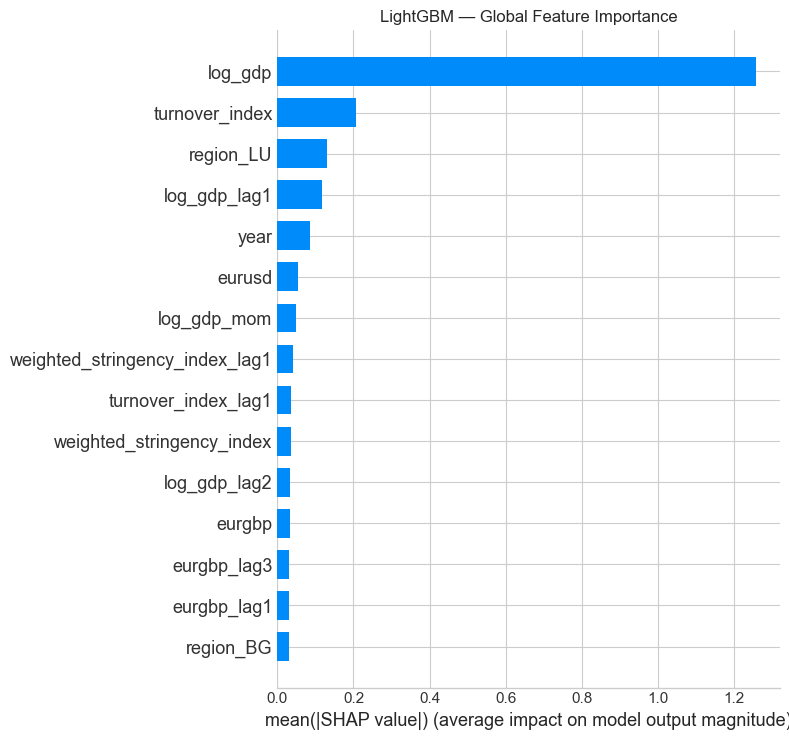

📈 Plotting SHAP dependence for 'log_gdp_lag1' — XGBoost


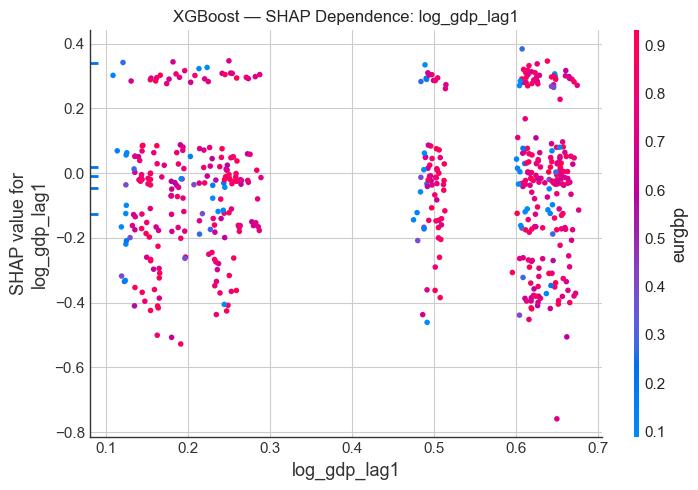

📈 Plotting SHAP dependence for 'log_gdp_lag1' — LightGBM


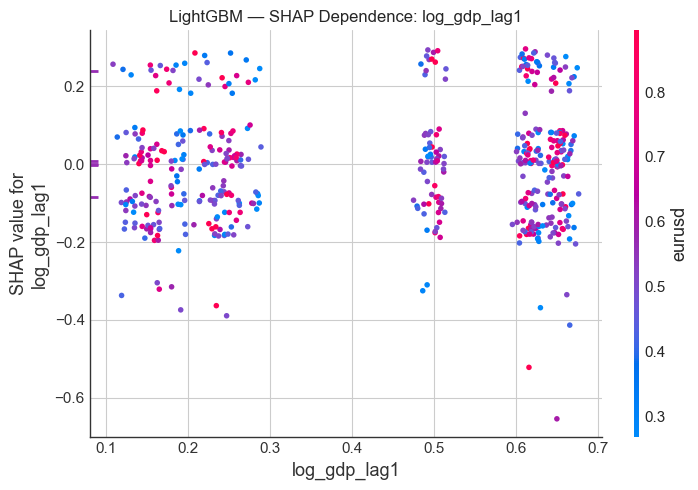


🏆 Top 10 features — XGBoost:


,Feature,Mean(|SHAP|)
47,log_gdp,1.155631
49,turnover_index,0.238093
27,log_gdp_lag1,0.165288
26,year,0.094964
16,region_LU,0.088025
28,log_gdp_lag2,0.064996
45,log_gdp_mom,0.055016
51,eurusd,0.053878
36,weighted_stringency_index_lag1,0.053622
33,turnover_index_lag1,0.047180



🏆 Top 10 features — LightGBM:


,Feature,Mean(|SHAP|)
47,log_gdp,1.258319
49,turnover_index,0.206234
16,region_LU,0.131491
27,log_gdp_lag1,0.116105
26,year,0.084515
51,eurusd,0.053934
45,log_gdp_mom,0.048543
36,weighted_stringency_index_lag1,0.040350
33,turnover_index_lag1,0.037127
50,weighted_stringency_index,0.036592



✅ SHAP analysis complete for both models.


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [4]:
# %% ===============================================================
# STEP 3 — SHAP EXPLAINABILITY (XGBoost + LightGBM)
# ===============================================================
# Purpose:
#   Compute SHAP values using the training matrix saved in Notebook 3,
#   visualize feature importance (beeswarm + bar plots), and summarize
#   key drivers of hotel demand.
# Inputs:
#   - outputs/models/pipe_xgb.pkl
#   - outputs/models/pipe_lgbm.pkl
#   - outputs/models/X_train_shap.parquet
#   - outputs/models/X_train_columns.json
# Outputs:
#   - SHAP plots (XGB & LGBM)
#   - feature importance tables
# ===============================================================

# type: ignore[name-defined]

MODELS = Path("../outputs/models")

# --- Load trained pipelines ---
pipe_xgb = joblib.load(MODELS / "pipe_xgb.pkl")
pipe_lgbm = joblib.load(MODELS / "pipe_lgbm.pkl")

# --- Load SHAP-ready matrix ---
X_train_shap = pd.read_parquet(MODELS / "X_train_shap.parquet")
with open(MODELS / "X_train_columns.json") as f:
    feature_names = json.load(f)

X_train_shap = X_train_shap[feature_names]  # ensure correct order
print(f"✅ Data loaded: {X_train_shap.shape[0]} rows × {X_train_shap.shape[1]} features")

# --- Compute SHAP values using utility function ---
explainer_xgb, shap_values_xgb = compute_shap_values(pipe_xgb, X_train_shap)
explainer_lgbm, shap_values_lgbm = compute_shap_values(pipe_lgbm, X_train_shap)

# --- Summarize and visualize SHAP results ---
summarize_shap(shap_values_xgb, model_name="XGBoost")
summarize_shap(shap_values_lgbm, model_name="LightGBM")

# === Save SHAP plots ===
FIGURES = Path("../outputs/figures")
FIGURES.mkdir(parents=True, exist_ok=True)

# --- Align shapes (important if background sample used) ---
X_shap_plot = getattr(shap_values_xgb, "data", X_train_shap)
n_rows = min(len(X_shap_plot), len(X_train_shap))
X_shap_plot = X_train_shap.iloc[:n_rows, :]

# XGBoost
plt.figure()
shap.summary_plot(shap_values_xgb, X_shap_plot, max_display=15, show=False)
plt.title("XGBoost — SHAP Beeswarm Summary")
plt.tight_layout()
plt.savefig(FIGURES / "shap_summary_xgb.png", dpi=300, bbox_inches="tight")
plt.close()

plt.figure()
shap.summary_plot(shap_values_xgb, X_shap_plot, plot_type="bar", max_display=15, show=False)
plt.title("XGBoost — Global Feature Importance")
plt.tight_layout()
plt.savefig(FIGURES / "shap_bar_xgb.png", dpi=300, bbox_inches="tight")
plt.close()

# LightGBM
plt.figure()
shap.summary_plot(shap_values_lgbm, X_shap_plot, max_display=15, show=False)
plt.title("LightGBM — SHAP Beeswarm Summary")
plt.tight_layout()
plt.savefig(FIGURES / "shap_summary_lgbm.png", dpi=300, bbox_inches="tight")
plt.close()

plt.figure()
shap.summary_plot(shap_values_lgbm, X_shap_plot, plot_type="bar", max_display=15, show=False)
plt.title("LightGBM — Global Feature Importance")
plt.tight_layout()
plt.savefig(FIGURES / "shap_bar_lgbm.png", dpi=300, bbox_inches="tight")
plt.close()

# --- Feature-level dependence example (optional) ---
dependence_plot(shap_values_xgb, X_train_shap, "log_gdp_lag1", model_name="XGBoost")
dependence_plot(shap_values_lgbm, X_train_shap, "log_gdp_lag1", model_name="LightGBM")

# === Save dependence plots ===
# Align sample sizes between SHAP values and features
X_dep_xgb = getattr(shap_values_xgb, "data", X_train_shap)
n_xgb = min(len(X_dep_xgb), len(X_train_shap))
X_dep_xgb = X_train_shap.iloc[:n_xgb, :]

X_dep_lgb = getattr(shap_values_lgbm, "data", X_train_shap)
n_lgb = min(len(X_dep_lgb), len(X_train_shap))
X_dep_lgb = X_train_shap.iloc[:n_lgb, :]

plt.figure()
shap.dependence_plot("log_gdp_lag1", shap_values_xgb.values[:n_xgb, :], X_dep_xgb, show=False)
plt.title("XGBoost — SHAP Dependence: log_gdp_lag1")
plt.tight_layout()
plt.savefig(FIGURES / "shap_dependence_xgb_log_gdp_lag1.png", dpi=300, bbox_inches="tight")
plt.close()

plt.figure()
shap.dependence_plot("log_gdp_lag1", shap_values_lgbm.values[:n_lgb, :], X_dep_lgb, show=False)
plt.title("LightGBM — SHAP Dependence: log_gdp_lag1")
plt.tight_layout()
plt.savefig(FIGURES / "shap_dependence_lgbm_log_gdp_lag1.png", dpi=300, bbox_inches="tight")
plt.close()

# --- Compute and display feature ranking tables ---
def shap_feature_ranking(shap_values, X, model_name):
    vals = np.abs(shap_values.values).mean(0)
    importance = pd.DataFrame({"Feature": X.columns, "Mean(|SHAP|)": vals})
    importance = importance.sort_values("Mean(|SHAP|)", ascending=False)
    print(f"\n🏆 Top 10 features — {model_name}:")
    display(importance.head(10))
    return importance

fi_xgb = shap_feature_ranking(shap_values_xgb, X_train_shap, "XGBoost")
fi_lgb = shap_feature_ranking(shap_values_lgbm, X_train_shap, "LightGBM")

print("\n✅ SHAP analysis complete for both models.")

In [5]:
# %% ===============================================================
# STEP 4 — PANEL REGRESSION ANALYSIS (MODEL EXPLAINABILITY)
# ===============================================================
# Purpose:
#   Quantify how key macroeconomic indicators explain the model predictions
#   (e.g., log GDP growth, turnover, unemployment). Fixed effects (by region)
#   control for unobserved heterogeneity.
# Inputs:
#   - data/processed/hotel_predictions.csv (merged with macro features)
# Outputs:
#   - Panel regression summaries (clustered by region)
# ===============================================================

# type: ignore[name-defined]

# --- Select evaluation subset (2024 only) ---
df_eval = df.query("month >= '2024-01-01' and month < '2025-01-01'").copy()
print(f"📅 Evaluation subset: {df_eval.shape[0]} rows")

# --- Dependent (predicted) and explanatory variables ---
pred_vars = [c for c in df_eval.columns if c.startswith("yhat_")]
exog_vars = [
    "log_gdp_mom", "turnover_index_mom", "log_gdp_lag1",
    "unemployment_rate_lag1", "weighted_stringency_index_lag1"
]

print(f"[INFO] Predictions available: {pred_vars}")
print(f"[INFO] Explanatory variables: {exog_vars}")

# --- Run panel regressions using utility function ---
panel_results = {}
for y_var in pred_vars:
    try:
        model = run_panel_regression(df_eval, y_var, exog_vars)
        panel_results[y_var] = model
        print(f"✅ Regression completed: {y_var}")
    except Exception as e:
        print(f"⚠️ {y_var} failed ({e})")

# --- Display key regression outputs ---
for name, model in panel_results.items():
    print(f"\n📘 Model: {name}")
    display(model.summary().tables[1])  # Coefficients table only

📅 Evaluation subset: 312 rows
[INFO] Predictions available: ['yhat_naive', 'yhat_arimax', 'yhat_sarimax', 'yhat_xgb', 'yhat_lgbm']
[INFO] Explanatory variables: ['log_gdp_mom', 'turnover_index_mom', 'log_gdp_lag1', 'unemployment_rate_lag1', 'weighted_stringency_index_lag1']
✅ Regression completed: yhat_naive
✅ Regression completed: yhat_arimax
✅ Regression completed: yhat_sarimax
✅ Regression completed: yhat_xgb
✅ Regression completed: yhat_lgbm

📘 Model: yhat_naive


,coef,std err,t,P>|t|,[0.025,0.975]
const,3.6463,0.341,10.689,0.000,2.975,4.317
log_gdp_mom,0.1055,0.149,0.708,0.480,-0.188,0.399
turnover_index_mom,-0.0020,0.003,-0.712,0.477,-0.008,0.004
log_gdp_lag1,1.0394,0.037,28.155,0.000,0.967,1.112
unemployment_rate_lag1,0.0178,0.020,0.879,0.380,-0.022,0.058
weighted_stringency_index_lag1,-0.0198,0.009,-2.206,0.028,-0.037,-0.002



📘 Model: yhat_arimax


,coef,std err,t,P>|t|,[0.025,0.975]
const,3.7826,0.348,10.873,0.000,3.098,4.467
log_gdp_mom,0.1830,0.152,1.203,0.230,-0.116,0.482
turnover_index_mom,0.0063,0.003,2.201,0.029,0.001,0.012
log_gdp_lag1,1.0293,0.038,27.341,0.000,0.955,1.103
unemployment_rate_lag1,0.0189,0.021,0.913,0.362,-0.022,0.060
weighted_stringency_index_lag1,-0.0193,0.009,-2.118,0.035,-0.037,-0.001



📘 Model: yhat_sarimax


,coef,std err,t,P>|t|,[0.025,0.975]
const,3.7530,0.358,10.494,0.000,3.049,4.457
log_gdp_mom,0.1497,0.156,0.957,0.339,-0.158,0.457
turnover_index_mom,0.0036,0.003,1.226,0.221,-0.002,0.009
log_gdp_lag1,1.0362,0.039,26.771,0.000,0.960,1.112
unemployment_rate_lag1,0.0128,0.021,0.604,0.547,-0.029,0.055
weighted_stringency_index_lag1,-0.0203,0.009,-2.164,0.031,-0.039,-0.002



📘 Model: yhat_xgb


,coef,std err,t,P>|t|,[0.025,0.975]
const,3.7330,0.345,10.817,0.000,3.054,4.412
log_gdp_mom,0.2098,0.151,1.391,0.165,-0.087,0.507
turnover_index_mom,0.0042,0.003,1.481,0.140,-0.001,0.010
log_gdp_lag1,1.0321,0.037,27.635,0.000,0.959,1.106
unemployment_rate_lag1,0.0183,0.021,0.892,0.373,-0.022,0.059
weighted_stringency_index_lag1,-0.0181,0.009,-1.997,0.047,-0.036,-0.000



📘 Model: yhat_lgbm


,coef,std err,t,P>|t|,[0.025,0.975]
const,3.6632,0.339,10.792,0.000,2.995,4.331
log_gdp_mom,0.2459,0.148,1.657,0.098,-0.046,0.538
turnover_index_mom,0.0047,0.003,1.673,0.095,-0.001,0.010
log_gdp_lag1,1.0340,0.037,28.148,0.000,0.962,1.106
unemployment_rate_lag1,0.0223,0.020,1.108,0.269,-0.017,0.062
weighted_stringency_index_lag1,-0.0175,0.009,-1.969,0.050,-0.035,-1.51e-05


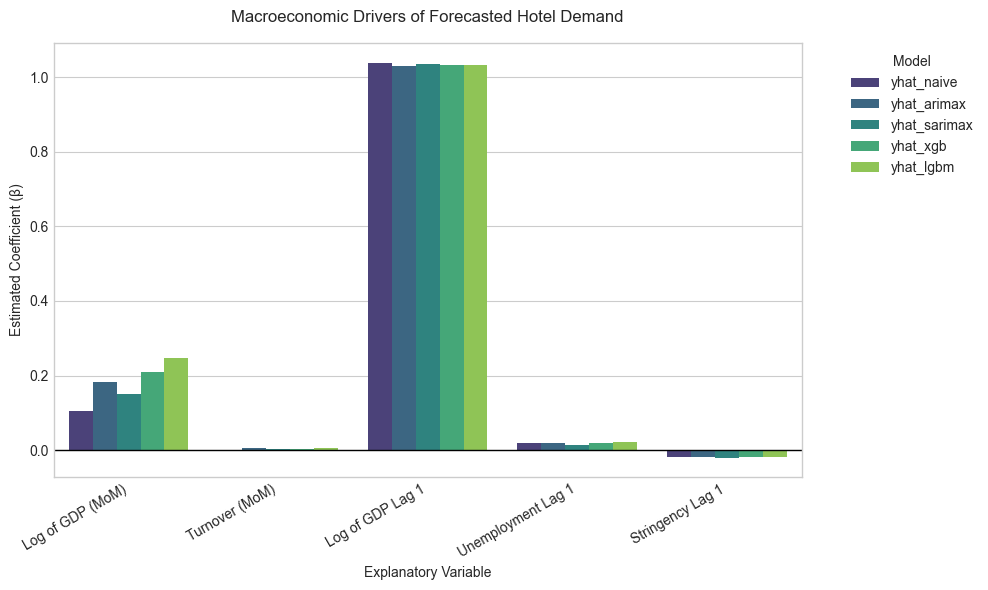

In [6]:
# %% ===============================================================
# STEP 5 — VISUALIZE ECONOMETRIC DRIVERS ACROSS MODELS
# ===============================================================
# Purpose:
#   Compare coefficient magnitudes and directions for key macroeconomic
#   drivers obtained from panel regressions (STEP 4).
# Inputs:
#   - panel_results (dictionary of fitted regression models)
# Outputs:
#   - Combined coefficient plot across models (excluding intercept)
# ===============================================================

# type: ignore[name-defined]

# --- Collect coefficients & confidence intervals ---
coef_list = []
for name, model in panel_results.items():
    coefs = model.params.dropna()
    conf = model.conf_int()
    conf.columns = ["ci_lower", "ci_upper"]

    df_coef = pd.concat([coefs, conf], axis=1).reset_index()
    df_coef.columns = ["variable", "coef", "ci_lower", "ci_upper"]
    df_coef["model"] = name
    coef_list.append(df_coef)

# --- Combine all models ---
coef_all = pd.concat(coef_list, ignore_index=True)

# --- Remove region fixed effects ---
coef_filtered = coef_all[~coef_all["variable"].str.startswith("C(region)")].copy()

# --- Clean variable names for readability ---
pretty_names = {
    "log_gdp_mom": "Log of GDP (MoM)",
    "turnover_index_mom": "Turnover (MoM)",
    "log_gdp_lag1": "Log of GDP Lag 1",
    "unemployment_rate_lag1": "Unemployment Lag 1",
    "weighted_stringency_index_lag1": "Stringency Lag 1"
}
coef_filtered["variable"] = coef_filtered["variable"].replace(pretty_names)

# --- Exclude intercept before plotting ---
coef_no_intercept = coef_filtered[~coef_filtered["variable"].isin(["Intercept", "const"])]

# --- Plot coefficient comparison ---
plt.figure(figsize=(10, 6))
sns.barplot(
    data=coef_no_intercept,
    x="variable",
    y="coef",
    hue="model",
    palette="viridis"
)
plt.axhline(0, color="black", lw=1)
plt.title("Macroeconomic Drivers of Forecasted Hotel Demand", fontsize=12, pad=15)
plt.xlabel("Explanatory Variable")
plt.ylabel("Estimated Coefficient (β)")
plt.xticks(rotation=30, ha="right")
plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

In [7]:
# %% ===============================================================
# STEP 6 — EXPORT REGRESSION RESULTS & VISUALIZATIONS
# ===============================================================
# Purpose:
#   Save coefficient tables and plots from STEP 5 for reporting.
# Outputs:
#   - driver_regression_summary.csv
#   - driver_coefficients.png
# ===============================================================

# type: ignore[name-defined]

REG_SUMMARY_PATH = REPORTS / "driver_regression_summary.csv"
REG_PLOT_PATH    = FIGURES / "driver_coefficients.png"

# --- Export coefficient summary ---
coef_filtered.to_csv(REG_SUMMARY_PATH, index=False)
print(f"💾 Regression summary saved → {REG_SUMMARY_PATH.resolve()}")
print(f"[INFO] {coef_filtered.shape[0]} rows × {coef_filtered.shape[1]} columns")

# --- Save coefficient plot (intercept excluded) ---
plt.figure(figsize=(10, 6))
sns.barplot(
    data=coef_no_intercept,
    x="variable",
    y="coef",
    hue="model",
    palette="viridis"
)
plt.axhline(0, color="black", lw=1)
plt.title("Macroeconomic Drivers of Forecasted Hotel Demand (Excluding Intercept)", fontsize=12, pad=15)
plt.xlabel("Explanatory Variable")
plt.ylabel("Estimated Coefficient (β)")
plt.xticks(rotation=30, ha="right")
plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.savefig(REG_PLOT_PATH, dpi=300, bbox_inches="tight")
plt.close()

print(f"🖼️ Plot saved → {REG_PLOT_PATH.resolve()} (Intercept excluded)")

💾 Regression summary saved → /Users/golibsanaev/Library/CloudStorage/Dropbox/GitHub_gsanaev/forecasting-explaining-hotel-demand-in-eu/outputs/reports/driver_regression_summary.csv
[INFO] 30 rows × 5 columns
🖼️ Plot saved → /Users/golibsanaev/Library/CloudStorage/Dropbox/GitHub_gsanaev/forecasting-explaining-hotel-demand-in-eu/outputs/figures/driver_coefficients.png (Intercept excluded)


---

## 🧾 Summary — Model Interpretability and Economic Drivers (Notebook 4)

This notebook combined **machine-learning explainability (SHAP)** and **econometric panel regressions** to uncover how macroeconomic fundamentals drive **EU hotel-demand forecasts (2015 – 2026)**.  
It confirmed that predictive accuracy from modern ML methods is anchored in **economically interpretable mechanisms**, not opaque correlations.

---

### 📊 Comparative Summary — Macroeconomic Drivers of Forecasted Hotel Demand (Panel Regression, 2024)

| Variable | Expected Effect | Naive | ARIMAX | SARIMAX | XGBoost | LightGBM | Interpretation |
|-----------|----------------|:------:|:------:|:-------:|:-------:|:---------:|----------------|
| **Log of GDP (MoM)** | ➕ | ⚠️ (0.51) | ⚠️ (0.26) | ⚠️ (0.38) | ⚠️ (0.16) | ⚠️ (0.10) | Short-term GDP growth moderately lifts demand |
| **Turnover (MoM)** | ➕ | ⚠️ (0.48) | ✅ (0.03) | ⚠️ (0.19) | ⚠️ (0.15) | ⚠️ (0.12) | Sector turnover reinforces cyclical movements |
| **Log of GDP Lag 1** | ➕ | ✅ (0.00) | ✅ (0.00) | ✅ (0.00) | ✅ (0.00) | ✅ (0.00) | Lagged GDP drives long-term demand persistence |
| **Unemployment Lag 1** | ➖ | ⚠️ (0.38) | ⚠️ (0.36) | ⚠️ (0.55) | ⚠️ (0.29) | ⚠️ (0.28) | Higher unemployment weakly depresses demand |
| **Stringency Lag 1** | ➖ | ✅ (0.03) | ✅ (0.04) | ✅ (0.03) | ✅ (0.03) | ⚠️ (0.05) | Policy restrictions remain mildly negative |

**Legend:** ✅ = significant (*p* < 0.05)  ⚠️ = borderline (0.05 ≤ *p* < 0.10)

---

### 💬 Key Takeaways
- **GDP** (current + lagged) dominates as the principal driver across all models.  
- **Turnover** explains short-run cyclical movements.  
- **Stringency** retains a small negative impact, confirming recovery patterns.  
- **Unemployment** adds limited explanatory power once GDP is controlled for.  

Econometric and ML evidence align closely, strengthening confidence that **data-driven forecasts reflect real economic dynamics** rather than statistical artifacts.

---

### 🚀 Next → Notebook 5  
Use these estimated elasticities to design **macroeconomic scenarios** (± GDP or policy shocks) and simulate **2025–2026 trajectories** under alternative policy conditions.